Test registration of small subset of public EMPIAR 12193 dataset

In [18]:
import matplotlib.pyplot as plt
import numpy as np
from ome_zarr.io import parse_url
from ome_zarr.reader import Reader
import os.path
from skimage.feature import match_descriptors, plot_matched_features, SIFT, ORB
from skimage.measure import ransac
from skimage.transform import rescale, AffineTransform

Load small subset of stitched slices

(2397, 2388) uint16


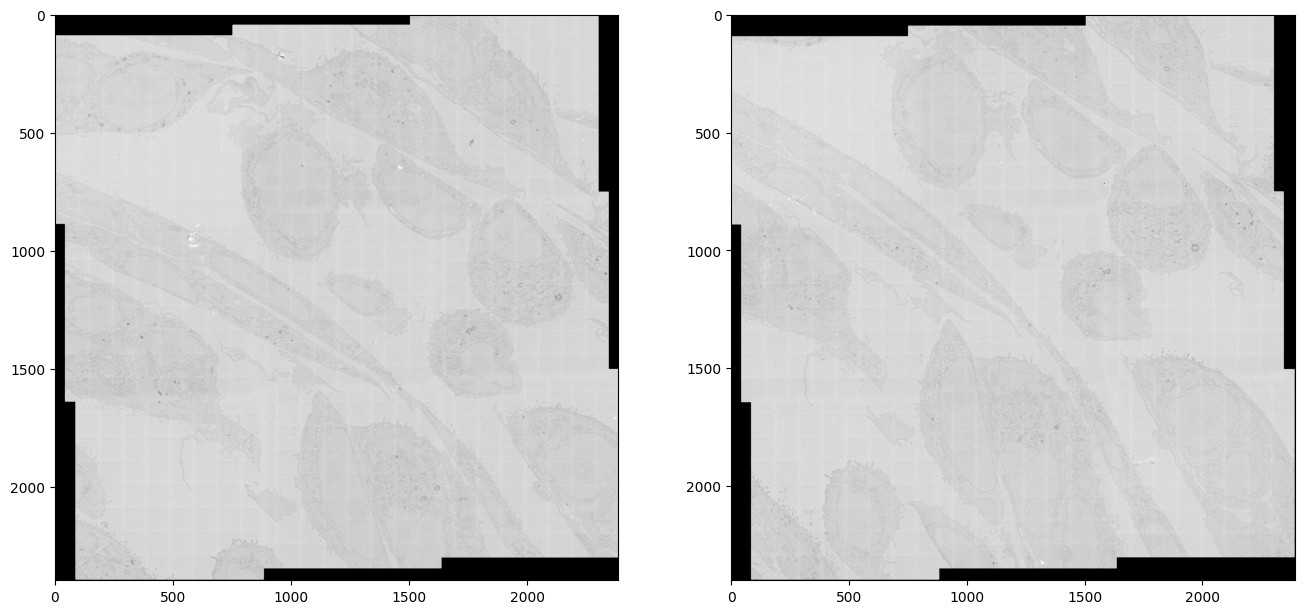

In [91]:
base_dir = 'data/12193/stitched'
filenames = ['S001.ome.zarr', 'S002.ome.zarr']
level = 0

images = []
for filename in filenames:
    reader = Reader(parse_url(os.path.join(base_dir, filename), mode="r"))
    nodes = list(reader())
    image_node = nodes[0]
    images.append(image_node.data[level])

print(images[0].shape, images[0].dtype)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
ax1.imshow(images[0], cmap='gray')
ax2.imshow(images[1], cmap='gray')
plt.show()


Pre-process images: normalize and downsample

Not using downsampling appears to give very poor results

(501, 499) float32


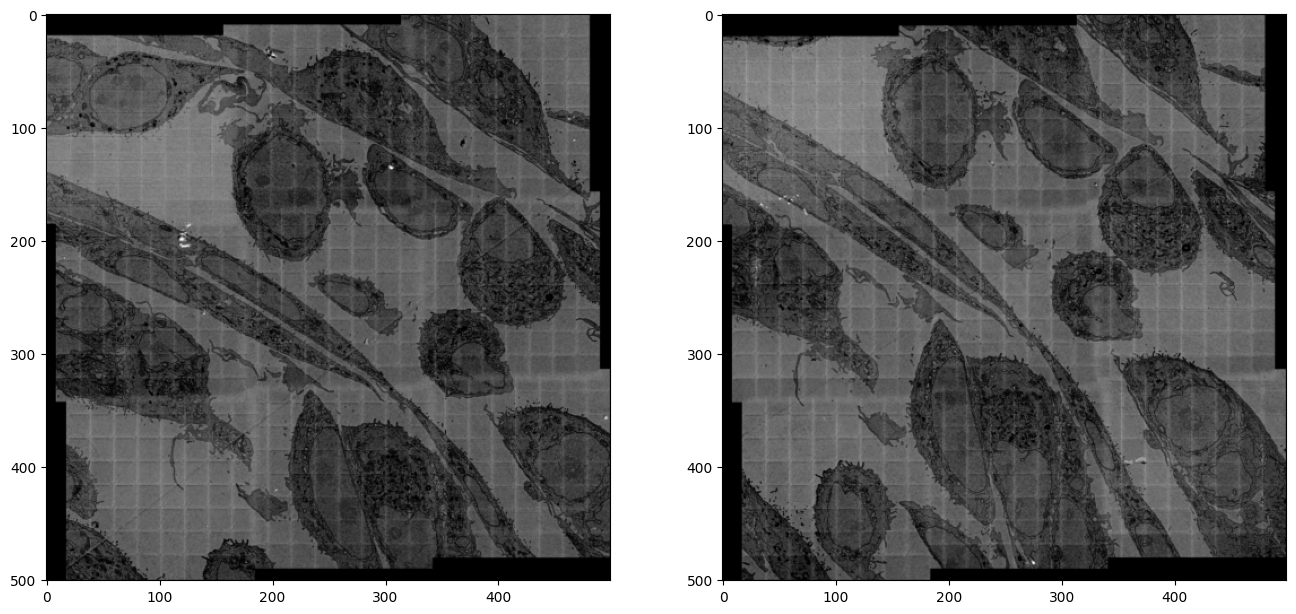

In [87]:
target_size = 500

source_type = images[0].dtype
maxval = 2 ** (8 * source_type.itemsize) - 1

norm_images = []
for image in images:
    float_image = image / np.float32(maxval)
    minimum = np.mean(float_image, dtype=np.float32)
    range = np.std(float_image, dtype=np.float32)
    norm_image = np.clip((float_image - minimum) / range, 0, 1)
    norm_images.append(norm_image)

images2 = []
scales = []
for image in norm_images:
    scale = min(target_size / np.linalg.norm(image.shape[:2]) * np.sqrt(2), 1)
    resized_image = rescale(image, scale)
    images2.append(resized_image)
    scales.append(scale)

print(images2[0].shape, images2[0].dtype)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
ax1.imshow(images2[0], cmap='gray')
ax2.imshow(images2[1], cmap='gray')
plt.show()

Feature extraction

Prefer using ORB as Open method.
Note SIFT performs extremely poor compared to ORB in this case.

In [93]:
#feature_model = SIFT(c_dog=0.1 / 3)
feature_model = ORB(n_keypoints=5000, downscale=np.sqrt(2))

points = []
descs = []
for image, scale in zip(images2, scales):
    feature_model.detect_and_extract(image)
    points.append(np.flip(feature_model.keypoints, axis=-1) / scale)     # rescale and convert to (z)yx
    descs.append(feature_model.descriptors)

print('# detected keypoints', [len(points1) for points1 in points])

# detected keypoints [4910, 4425]


Feature matching

matching is using Lowe ratio

threshold is used for RANSAC to filter outliers

In [89]:
min_samples = 5
threshold = 50

matches = match_descriptors(descs[0], descs[1], cross_check=True, max_ratio=0.92)
print('# matches', len(matches))

points1, points2 = points
match_points1 = np.array([points1[match[0]] for match in matches])
match_points2 = np.array([points2[match[1]] for match in matches])
transform, inliers = ransac((match_points1, match_points2), AffineTransform, min_samples=min_samples,
                                   residual_threshold=threshold, max_trials=1000)

print('# inliers', np.sum(inliers))

# matches 331
# inliers 94


Draw matching keypoints, inliers in green color

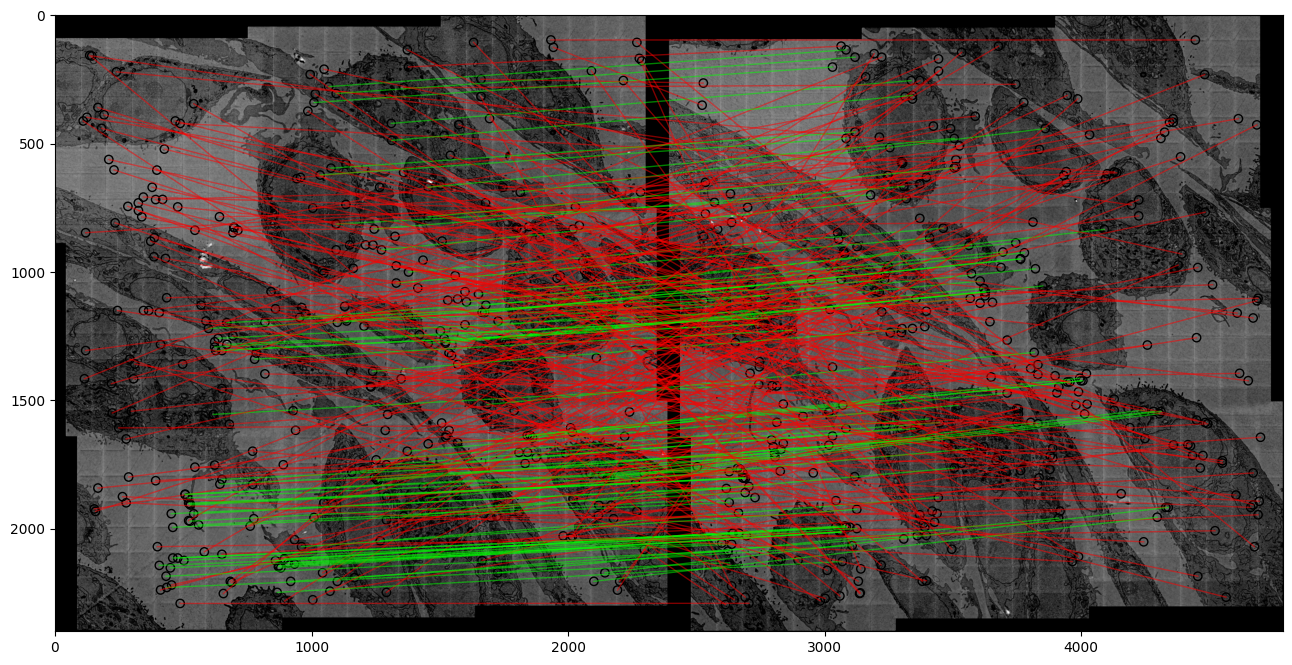

In [90]:
fig, ax = plt.subplots(figsize=(16,8))

out_images = norm_images
shape = np.max([image.shape for image in images], axis=0)
image = np.concatenate([
    np.pad(out_images[0], ((0, shape[0] - out_images[0].shape[0]), (0, shape[1] - out_images[0].shape[1]))),
    np.pad(out_images[1], ((0, shape[0] - out_images[1].shape[0]), (0, shape[1] - out_images[1].shape[1])))
], axis=1)
offset2 = [0, shape[1]]
ax.imshow(image, cmap='gray')

keypoints_color = 'black'
ax.scatter(
    match_points1[:, 1],
    match_points1[:, 0],
    facecolors='none',
    edgecolors=keypoints_color,
)
ax.scatter(
    match_points2[:, 1] + offset2[1],
    match_points2[:, 0] + offset2[0],
    facecolors='none',
    edgecolors=keypoints_color,
)

for i, match in enumerate(matches):
    color = 'lime' if inliers[i] else 'red'
    index1, index2 = match
    ax.plot(
        (points1[index1, 1], points2[index2, 1] + offset2[1]),
        (points1[index1, 0], points2[index2, 0] + offset2[0]),
        '-', linewidth=1, alpha=0.5, color=color,
    )

plt.show()